# GNN Goal Recognition
Questo notebook addestra una Graph Neural Network per il riconoscimento del goal di un agente che si muove su mappe a griglia 4-connected

## Setup e Import

Questa sezione prepara l'ambiente di lavoro, importa le librerie necessarie e garantisce la riproducibilità degli esperimenti fissando il seed.

In [1]:
#pip install torch_geometric
#pip install wandb -qU
#pip install networkx==3.4.2
#pip install torchinfo

In [25]:
# --- 1. Python Standard Library ---
import json
import math
import os
import pprint
import random
from dataclasses import dataclass
from typing import List, Tuple

# --- 2. Third-Party Scientific, Data & Utilities ---
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
import scipy.sparse.linalg as linalg
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

# --- 3. PyTorch Core ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

# --- 4. PyTorch Geometric (GNNs) & Scatter ---
# Data handling
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx, softmax as pyg_softmax
from torch_geometric.utils import get_laplacian, to_scipy_sparse_matrix

# Neural Network Layers
from torch_geometric.nn import GCNConv, GraphNorm

# Scatter operations (per aggregazioni custom)
from torch_scatter import scatter_max, scatter_sum, scatter_mean

In [26]:
def set_seed(seed: int = 42):
    """
    Fissa il seed per garantire la riproducibilità degli esperimenti.
    """
    # 1. Python standard
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    # 2. NumPy
    np.random.seed(seed)
    
    # 3. PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Se usi più GPU
    
    # 4. CuDNN (Algoritmi di convoluzione)
    # Rende il training deterministico, ma potrebbe rallentare leggermente
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Seed fissato globalmente a: {seed}")

# --- CHIAMA LA FUNZIONE SUBITO ---
set_seed(42)

Seed fissato globalmente a: 42


## Data Loading & Processing

In [4]:
@dataclass
class Map:
    V: List[List[Tuple[int, int, int]]]
    E: List[Tuple[int, int]]
    Y: List[List[int]]
    O: List[List[int]]
    Optimality: List[float]
    AvgLength: float
    ObstaclePerc: float

In [5]:
class MyDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        super().__init__('.', transform)
        self.data, self.slices = self.collate(data_list)

    @property
    def num_features(self):
        return self[0].num_node_features

    @property
    def num_classes(self):
        y_all = torch.cat([d.y for d in self])
        return int(y_all.max().item() + 1)

In [6]:
def load_maps_from_drive_unified(type,size):
    """
    Carica tutte le istanze di Map insieme dal file unified
    Restituisce una lista di oggetti Map.
    """
    if size not in [8, 16, 32, 128]:
        print("size deve essere 16, 32 o 128")
        return []

    all_maps = []
    file_path = f"{type}{size}.json"
    try:
        with open(file_path, "r") as f:
            data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        print(f"File {file_path} non trovato o non leggibile")
        return None

    if not data:
        print(f"File {file_path} vuoto")
        return None


    all_maps.extend([Map(**map_dict) for map_dict in data])

    return all_maps

In [ ]:
class GoalRecognitionDataset(Dataset):
    """
    Dataset per il Goal Recognition che trasforma traiettorie su griglia in grafi PyG.

    Questa classe gestisce la conversione delle mappe e dei percorsi in una serie di 
    oggetti 'Data', dove ogni oggetto rappresenta lo stato del sistema a un determinato 
    step temporale della traiettoria.

    Args:
        maps (List[Map]): Lista di oggetti Map caricati dal JSON.
    """    
    def __init__(self, maps, transform=None):
        super().__init__(None, transform)
        self.maps = maps

    def _compute_pe(self, edge_index_tensor, num_nodes, k_dim=4):
        """
        Calcola i Laplacian Positional Encodings (PE) per i nodi del grafo.

        I PE permettono alla GNN di comprendere la struttura spaziale e la distanza 
        relativa tra i nodi, sopperendo all'invarianza per permutazione delle GNN.
        Vengono calcolati tramite la decomposizione spettrale della matrice Laplaciana.
        """
        # 1. Laplaciano
        L_edge_index, L_edge_weight = get_laplacian(
            edge_index_tensor, 
            normalization='sym', 
            num_nodes=num_nodes
        )
        
        # 2. Converti a SciPy
        L = to_scipy_sparse_matrix(L_edge_index, L_edge_weight, num_nodes)

        # 3. Eigendecomposition
        try:
            # k_dim + 1 perché il primo è banale
            eig_vals, eig_vecs = linalg.eigsh(L, k=k_dim + 1, which='SM', tol=1e-2)
            pe = torch.from_numpy(eig_vecs[:, 1:]).float() # Scarta il primo
        except:
            # Fallback se il grafo è troppo piccolo o disconnesso
            pe = torch.zeros((num_nodes, k_dim))
        
        # Padding se necessario
        if pe.shape[1] < k_dim:
            padding = torch.zeros((num_nodes, k_dim - pe.shape[1]))
            pe = torch.cat([pe, padding], dim=1)

        # Sign Flipping (Randomizzazione del segno per robustezza)
        # Nota: Se vuoi risultati deterministici per validazione, togli questo blocco o fissa il seed
        sign = 2 * torch.randint(0, 2, (1, k_dim)) - 1
        pe = pe * sign
        
        return pe

    def generate_entries(self, map_index, path_index, print_or_not, percentage=100):
        """
        Genera una lista di grafi (uno per ogni step) per una specifica traiettoria.

        Per ogni step del percorso:
        1. Codifica lo stato dei nodi (Visitato, Agente, Futuro).
        2. Concatena i Positional Encodings.
        3. Applica uno sharpening (esponente alpha) alla distribuzione target Y.
        4. Allega metadati per l'analisi post-training.
        """
        entries = []
        
        current_map = self.maps[map_index]
        
        edge_index = torch.tensor(current_map.E, dtype=torch.long).t().contiguous()
        num_nodes = len(current_map.V[path_index])
        
        pe = self._compute_pe(edge_index, num_nodes, k_dim=4) 

        len_entr = len(current_map.O[path_index])
        new_len = int((100-percentage)*len_entr/100)
        if new_len < 2:
            new_len = 2

        for step in range(new_len, len_entr+1):
            V_mod = [row.copy() for row in current_map.V[path_index]]

            visited = current_map.O[path_index][:step-1]
            agent_pos = current_map.O[path_index][step-1]
            future = current_map.O[path_index][step:]

            if(print_or_not):
                print(visited)

            for v in visited:
                V_mod[v] = [0,0,1]

            V_mod[agent_pos] = [0,1,0]

            for f in future:
                V_mod[f] = [1,0,0]

            x_base = torch.tensor(V_mod, dtype=torch.float)
            
            x_final = torch.cat([x_base, pe], dim=1)

            y = torch.tensor(current_map.Y[path_index], dtype=torch.float)
            alpha = 6.0
            y_transformed = y ** alpha
            y_transformed = y_transformed / y_transformed.sum()

            data_item = Data(x=x_final, edge_index=edge_index, y=y_transformed)

            #Aggiunta dei metadati
            val_obstacle_perc = current_map.ObstaclePerc
            val_avg_len = current_map.AvgLength
            val_optimality = current_map.Optimality[path_index]
            current_completion = step / len_entr

            data_item.obstacle_perc = torch.tensor([val_obstacle_perc], dtype=torch.float)
            data_item.avg_len       = torch.tensor([val_avg_len], dtype=torch.float)
            data_item.optimality    = torch.tensor([val_optimality], dtype=torch.float)
            data_item.path_completion = torch.tensor([current_completion], dtype=torch.float)
            
            entries.append(data_item)

        return entries

    def generate_all_entries(self):
        """
        Processa ricorsivamente tutte le mappe e tutti i percorsi disponibili.
        """
        entries = []
        for map_idx in range(len(self.maps)):
            for path_idx in range(len(self.maps[map_idx].O)):
                for entry in self.generate_entries(map_idx, path_idx, False, 100): 
                    entries.append(entry)
        return entries
    
    def generate_subset_entries(self, map_indices_list):
        """
        Genera le entries (grafi) solo per le mappe specificate nella lista.
        Utile per creare set di Train/Test separati per mappe.
        """
        entries = []
        # Qui iteriamo SOLO sugli indici che ci vengono passati (es. [0, 4, 12...])
        for map_idx in map_indices_list:
            
            if map_idx >= len(self.maps):
                continue
                
            # Iteriamo su tutti i percorsi di QUELLA mappa specifica
            for path_idx in range(len(self.maps[map_idx].O)):
                path_entries = self.generate_entries(map_idx, path_idx, False, 100)
                entries.extend(path_entries)
                
        return entries

### Caricamento e Split dataset

In [8]:
size=8
maps=load_maps_from_drive_unified("DfsRandomJump",size)
goalRecognitionDataset = GoalRecognitionDataset(maps)

In [9]:
# 1. Recuperiamo tutti gli indici disponibili
num_total_maps = len(goalRecognitionDataset.maps)
all_indices = list(range(num_total_maps))

# Mischiamo casualmente l'ordine delle mappe (con seed fisso per riproducibilità)
random.seed(42)
random.shuffle(all_indices)

# 2. Definiamo quante mappe tenere "segrete" (Unseen)
NUM_UNSEEN_MAPS = 10 

# Indici per il Test Set "Puro" (Mappe mai viste)
unseen_indices = all_indices[:NUM_UNSEEN_MAPS]

# Indici per il "Pool" di apprendimento (Mappe viste)
seen_indices = all_indices[NUM_UNSEEN_MAPS:]

print(f"Mappe totali: {num_total_maps}")
print(f"Mappe Unseen (Test Set 1): {unseen_indices}")
print(f"Mappe Seen (Train/Val/Test2): {len(seen_indices)} mappe")

# 3. Generazione dei Dati usando il NUOVO metodo
print("Generazione dati Unseen...")
test_unseen_data = goalRecognitionDataset.generate_subset_entries(unseen_indices)

print("Generazione dati Seen Pool...")
seen_data_pool = goalRecognitionDataset.generate_subset_entries(seen_indices)

# 4. Split del pool "Seen" in Train, Val e Test "Seen"
# Ora lavoriamo sulle entries (liste di grafi), non più sulle mappe
total_seen_entries = len(seen_data_pool)

# Esempio: 80% Train, 10% Val, 10% Test (delle mappe conosciute)
n_train = int(0.8 * total_seen_entries)
n_val   = int(0.1 * total_seen_entries)
n_test_seen = total_seen_entries - n_train - n_val

# Mischiamo le ENTRIES (non le mappe, quelle sono già fissate)
# Questo serve perché dentro una mappa ci sono tanti percorsi, e vogliamo mischiarli
random.shuffle(seen_data_pool)

train_dataset = seen_data_pool[:n_train]
val_dataset   = seen_data_pool[n_train : n_train + n_val]
test_seen_dataset = seen_data_pool[n_train + n_val :]

# 5. Creazione dataset finale di Test (Unione dei due pezzi)
# Questo contiene SIA mappe mai viste SIA percorsi nuovi di mappe viste
full_test_dataset = test_unseen_data + test_seen_dataset 

print(f"\n--- Riepilogo Dimensioni Dataset ---")
print(f"TRAIN: {len(train_dataset)}")
print(f"VAL:   {len(val_dataset)}")
print(f"TEST (Total): {len(full_test_dataset)}")
print(f"   -> Unseen Maps: {len(test_unseen_data)}")
print(f"   -> Seen Maps:   {len(test_seen_dataset)}")

# 6. Loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(full_test_dataset, batch_size=32, shuffle=False)

# Loader extra per analisi specifica
test_loader_unseen = DataLoader(test_unseen_data, batch_size=32, shuffle=False)
test_loader_seen   = DataLoader(test_seen_dataset, batch_size=32, shuffle=False)

Mappe totali: 1000
Mappe Unseen (Test Set 1): [776, 507, 895, 922, 33, 483, 85, 750, 354, 523]
Mappe Seen (Train/Val/Test2): 990 mappe
Generazione dati Unseen...


Generazione dati Seen Pool...

--- Riepilogo Dimensioni Dataset ---
TRAIN: 120944
VAL:   15118
TEST (Total): 16733
   -> Unseen Maps: 1614
   -> Seen Maps:   15119


## Modello GNN

In [ ]:
SAVE_DIR = "./gnn/"
MODEL_NAME = "node_cls_soft.pth"

# Dizionario per salvare i migliori parametri globalmente
best_params = {}

class NodeClassificator(nn.Module):
    """
    Graph Neural Network per la classificazione dei nodi applicata al Goal Recognition.
    
    L'architettura utilizza layer di convoluzione grafocentrale (GCN) con l'aggiunta di 
    connessioni residuali e una testa di classificazione che concatena le rappresentazioni 
    di tutti i livelli (Jumping Knowledge) per catturare informazioni a diverse scale.
    """
    def __init__(self, in_channels, hidden_channels, num_layers, dropout=0.0):
        super(NodeClassificator, self).__init__()
        
        self.dropout_p = dropout
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        #self.relu = nn.ReLU()
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        #self.relu = nn.ELU()
        self.dropout = nn.Dropout(p=dropout)

        # Costruzione dinamica dei layer GCN
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.bns.append(GraphNorm(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.bns.append(GraphNorm(hidden_channels))
        self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.bns.append(GraphNorm(hidden_channels))

        self.lin = nn.Linear(hidden_channels* num_layers, 1)

    def forward(self, x, edge_index, batch=None):

        xs = []

        for i, (conv, bn) in enumerate(zip(self.convs, self.bns)):
            x_in = x  # <--- Salviamo l'input per la connessione residuale
            
            x = conv(x, edge_index) # Convoluzione
            x = self.bns[i](x, batch)
            #x = bn(x)               # Batch Normalization (stabilizza i gradienti)
            x = self.relu(x)        # Attivazione
            x = self.dropout(x)     # Dropout

            # Se la dimensione non cambia (cioè non è il primo layer se in != hidden), sommiamo
            if x.shape == x_in.shape:
                x = x + x_in

            xs.append(x)    
        
        x_all = torch.cat(xs, dim=-1)

        # Restituisce LOGITS (punteggi non normalizzati) per stabilità numerica
        logits = self.lin(x_all).squeeze(-1)
        return logits

    # ------------------------------- TRAINING --------------------------------

    def train_gcn(self, train_loader, val_loader, optimizer, device, num_epochs, patience=10):
        """
        Gestisce l'intero ciclo di addestramento del modello con Early Stopping e logging su WandB.

        La funzione implementa una "Mixed Loss":
        - KL Divergence: ottimizza la forma della distribuzione (heatmap).
        - NLL Loss: forza la rete a dare la massima probabilità al goal reale.
        """
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6, verbose=True
        )

        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        k_val=10

        for epoch in range(num_epochs):
            self.train()
            total_loss = 0
            total_kl = 0
            total_ce = 0

            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()

                # 1. Ottieni Logits
                logits = self(batch.x, batch.edge_index, batch.batch)
                
                # 2. Calcola Log-Probabilità
                probs = pyg_softmax(logits, batch.batch)
                log_probs = torch.log(probs + 1e-15)

                # 2. LOSS 1: KL DIVERGENCE (Topologia - Soft)
                loss_kl = torch.nn.functional.kl_div(log_probs, batch.y, reduction="sum") / batch.num_graphs

                # 3. LOSS 2: NLL (Decisione - Hard)
                # Dobbiamo trovare l'indice del vero goal per ogni grafo nel batch
                # Poiché i grafi hanno dimensioni variabili o sono batchati, lo facciamo iterando
                loss_ce = 0
                num_graphs = batch.num_graphs
                
                for i in range(num_graphs):
                    mask = batch.batch == i
                    
                    # Sotto-sezioni per il singolo grafo i
                    sub_target = batch.y[mask]      # Heatmap target
                    sub_log_probs = log_probs[mask] # Log-probs predette
                    
                    # Troviamo il VERO goal (il nodo con valore massimo nel target)
                    true_goal_idx = sub_target.argmax()
                    
                    # NLL Loss: prendiamo la -log_prob del nodo corretto
                    loss_ce += -sub_log_probs[true_goal_idx]
                    
                loss_ce = loss_ce / num_graphs

                # MIXED LOSS: Combiniamo le due loss. Puoi bilanciarle (es. 0.5 e 0.5)
                loss = 0.4 * loss_kl + 0.6 * loss_ce
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_kl += loss_kl.item()
                total_ce += loss_ce.item()

            # Medie per epoca
            avg_train_loss = total_loss / len(train_loader)

            # Validazione (Top-1 e Top-K)
            val_loss, val_top1, val_topk = self.eval_gcn(val_loader, device, k=k_val)

            scheduler.step(val_loss)
            current_lr = optimizer.param_groups[0]['lr']

            print(f"Epoch {epoch:03d} | "
                  f"LR: {current_lr:.6f} | "
                  f"Train Loss: {avg_train_loss:.4f} (KL:{total_kl/len(train_loader):.2f} CE:{total_ce/len(train_loader):.2f}) | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Top1: {val_top1:.2%} | "
                  f"Top{k_val}: {val_topk:.2%}")
            
            grad_stats = {}
            # Calcoliamo la norma dei gradienti solo se wandb è attivo
            if wandb.run is not None:
                for name, param in self.named_parameters():
                    if param.grad is not None:
                        # Calcola la norma (intensità) del gradiente
                        grad_norm = param.grad.norm().item()
                        # Salva con un nome chiaro, es: "grads/convs.0.weight"
                        grad_stats[f"grads/{name}_norm"] = grad_norm

                        # Controlla percentuale di zeri (utile per Dead ReLU)
                        n_zeros = (param.grad == 0).sum().item()
                        n_total = param.grad.numel()
                        grad_stats[f"grads/{name}_sparsity"] = n_zeros / n_total
                
                log_dict = {
                    "epoch": epoch, 
                    "lr": current_lr,
                    "train_loss": avg_train_loss,
                    "train_loss_kl": total_kl/len(train_loader),
                    "train_loss_ce": total_ce/len(train_loader),
                    "val_loss": val_loss, 
                    "val_top1": val_top1, 
                    "val_topk": val_topk
                }
                log_dict.update(grad_stats)
                wandb.log(log_dict)

            # Checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                
                best_params.update({
                    'optimizer': optimizer.__class__.__name__,
                    'dropout': self.dropout_p,
                    'epochs': epoch,
                    'learning_rate': optimizer.param_groups[0]['lr'],
                    'batch_size': getattr(train_loader.dataset, 'batch_size', None) if hasattr(train_loader, 'dataset') else train_loader.batch_size,
                    'num_layers': len(self.convs),
                    'hidden_channels': self.convs[0].out_channels,
                    'in_channels': self.convs[0].in_channels
                })

                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR, exist_ok=True)
                run_id = wandb.run.id if wandb.run else "manual"
                MODEL_NAME = f"model_{run_id}.pth"    
                torch.save(self.state_dict(), os.path.join(SAVE_DIR, MODEL_NAME))
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    # ------------------------------- EVAL --------------------------------            

    @torch.no_grad()
    def eval_gcn(self, loader, device, k=10):
        """
        Valuta il modello calcolando loss e accuratezza Top-1 e Top-K
        """
        self.eval()
        total_loss = 0
        total_top1 = 0
        total_topk = 0
        total_graphs = 0
        
        for batch in loader:
            batch = batch.to(device)
            
            # Forward (Logits -> Probs)
            logits = self(batch.x, batch.edge_index, batch.batch)
            probs = pyg_softmax(logits, batch.batch)
            log_probs = torch.log(probs + 1e-15)

            loss_kl = torch.nn.functional.kl_div(log_probs, batch.y, reduction="sum") / batch.num_graphs
            
            loss_ce = 0
            
            # Calcolo Metriche per Grafo
            num_graphs = batch.num_graphs
            for i in range(num_graphs):
                mask = batch.batch == i
                sub_probs = probs[mask]
                sub_target = batch.y[mask]
                
                true_goal_idx = sub_target.argmax().item()
                
                # Loss CE per validazione
                loss_ce += -torch.log(sub_probs[true_goal_idx] + 1e-15)

                # Top-1
                if sub_probs.argmax().item() == true_goal_idx:
                    total_top1 += 1
                    
                # Top-K
                curr_k = min(k, len(sub_probs))
                _, top_k_indices = sub_probs.topk(curr_k)
                
                if true_goal_idx in top_k_indices.tolist():
                    total_topk += 1

            loss_ce = loss_ce / num_graphs        
            
            total_loss += (0.4 * loss_kl + 0.6 * loss_ce).item()
            total_graphs += num_graphs
            
        return total_loss / len(loader), total_top1 / total_graphs, total_topk / total_graphs

## Configurazione Esperimento - WanDB Sweep

Inserire la propria key per effetture il login a wandb

In [11]:
wandb.login(key="38de765b09e71e9b6b33218b7ade62f2349d81c0")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/deeplearning/.netrc
wandb: Currently logged in as: m-lizza002 (m-lizza002-university-of-brescia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Per definire lo sweep, decidere i parametri in 'parameters_dict'.
Ogni volta che si modificano questi parametri bisogna creare un nuovo sweep.

In [12]:
parameters_dict = {
    # --- Ottimizzazione ---
    'optimizer': {
        'values': ['Adam']  # Solo Adam, SGD non va bene qui
    },
    'learning_rate': {
        # Cerca valori tra 0.01 e 0.005 (logaritmico)
        'distribution': 'log_uniform_values',
        'min': 0.0005,
        'max': 0.001
    },
    'batch_size': {
        'values': [32, 64]
    },
    'epochs': {
        'value': 100
    },

    # --- Architettura ---
    'num_layers': {
        'value': 4
    },
    'hidden_channels': {
        # Unica dimensione per tutti i layer interni per semplicità
        'value': 64
    },
    'dropout': {
        'values': [0.2, 0.3]
    }
}

sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_topk',
        'goal': 'maximize'
    },
    'parameters': parameters_dict
}

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_topk'},
 'parameters': {'batch_size': {'values': [32, 64]},
                'dropout': {'values': [0.2, 0.3]},
                'epochs': {'value': 100},
                'hidden_channels': {'value': 64},
                'learning_rate': {'distribution': 'log_uniform_values',
                                  'max': 0.001,
                                  'min': 0.0005},
                'num_layers': {'value': 4},
                'optimizer': {'values': ['Adam']}}}


Eseguire solo quando si crea un nuovo sweep (copiare lo sweep_id nella cella sottostante, per le future esecuzioni)

In [13]:
#sweep_id = wandb.sweep(sweep_config, project="Node_Classificator")

Eseguire per attivare lo sweep ogni volta che bisogna usarlo

In [14]:
project = "m-lizza002-university-of-brescia/Node_Classificator"
sweep_id = "8uzklkf6"

FULL_SWEEP_ID = f"{project}/{sweep_id}"
SWEEP_PATH = f"{project}/sweeps/{sweep_id}"

## Esecuzione Training

In [ ]:
def train_sweep(config=None):
    """
    Funzione wrapper per l'esecuzione di iperparametri tramite Weights & Biases (WandB) Sweep.

    Questa funzione viene chiamata dall'agente di WandB per ogni combinazione di parametri 
    definita nello spazio di ricerca. Si occupa di:
    1. Inizializzare il run e configurare i parametri.
    2. Istanziare dinamicamente il modello NodeClassificator.
    3. Selezionare l'ottimizzatore richiesto (es. Adam, SGD).
    4. Avviare il ciclo di addestramento e validazione.
    """
    with wandb.init(config=config) as run:
        config = wandb.config

        run_name = (
            f"Adam"
            f"-L{config.num_layers}"     # Numero di Layer
            f"-H{config.hidden_channels}" # Dimensione Hidden
            f"-lr{config.learning_rate:.4f}"
            f"-bs{config.batch_size}"
        )
        run.name = run_name

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # --- Inizializzazione Modello Dinamico ---
        model = NodeClassificator(
            in_channels=7, # (Visitato, Agente, Futuro) + 4 Laplacian 
            hidden_channels=config.hidden_channels,
            num_layers=config.num_layers,
            dropout=config.dropout
        ).to(device)

        # Optimizer
        optimizer = getattr(optim, config.optimizer)(
            model.parameters(), lr=config.learning_rate
        )

        # Training
        model.train_gcn(
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            device=device,
            num_epochs=config.epochs,
            patience=10
        )

        print("BEST PARAMS:", best_params)

'Count' rappresenta il numero di run da eseguire

In [62]:
if wandb.run is not None:
    wandb.finish()

wandb.agent(FULL_SWEEP_ID, function=train_sweep, count=5)

wandb: Agent Starting Run: 61nntoda with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_channels: 64
wandb: 	learning_rate: 0.0006381325575088698
wandb: 	num_layers: 4
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.000638 | Train Loss: 3.0770 (KL:2.20 CE:3.66) | Val Loss: 3.0428 | Top1: 6.17% | Top10: 37.95%
Epoch 001 | LR: 0.000638 | Train Loss: 3.0286 (KL:2.16 CE:3.61) | Val Loss: 2.9918 | Top1: 6.30% | Top10: 39.44%
Epoch 002 | LR: 0.000638 | Train Loss: 3.0044 (KL:2.14 CE:3.58) | Val Loss: 2.9733 | Top1: 6.38% | Top10: 40.44%
Epoch 003 | LR: 0.000638 | Train Loss: 2.9898 (KL:2.13 CE:3.56) | Val Loss: 2.9577 | Top1: 6.54% | Top10: 40.99%
Epoch 004 | LR: 0.000638 | Train Loss: 2.9755 (KL:2.12 CE:3.55) | Val Loss: 2.9474 | Top1: 6.69% | Top10: 41.04%
Epoch 005 | LR: 0.000638 | Train Loss: 2.9640 (KL:2.11 CE:3.53) | Val Loss: 2.9373 | Top1: 6.72% | Top10: 41.49%
Epoch 006 | LR: 0.000638 | Train Loss: 2.9552 (KL:2.10 CE:3.52) | Val Loss: 2.9285 | Top1: 6.86% | Top10: 42.00%
Epoch 007 | LR: 0.000638 | Train Loss: 2.9489 (KL:2.09 CE:3.52) | Val Loss: 2.9198 | Top1: 6.97% | Top10: 42.78%
Epoch 008 | LR: 0.000638 | Train Loss: 2.9430 (KL:2.09 CE:3.51) | Val Loss: 2.9163 | Top1: 7.11%

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
grads/bns.0.bias_norm,▁▁▁▁▁▂▂▃▂▂▃▂▂▂▂▃▂▂▄▃▄▆▃▄▄▄▄▄▃▄▄▃▄▄▄▄▄█▄▄
grads/bns.0.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.mean_scale_norm,▁▂▂▂▂▃▃▂▂▃▃▂▂▃▂▂▅▃▃▃▃▄▅▂▃▃▃▅▄▃▃▂▂▃▄▃▃█▃▃
grads/bns.0.mean_scale_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.weight_norm,▁▁▁▁▂▃▂▂▃▃▃▃▃▅▃▆▄▃▃▄▆▄▆▆▃▇▅▅▇▅▄▅▅█▆▇▅▆▅█
grads/bns.0.weight_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.bias_norm,▁▂▁▂▂▂▃▂▃▃▃▃▃▃▄▄▅▄▄▅▄▅▅▅▇▆▇▇▆▆▇▆▅█▇▇▆▇▆█
grads/bns.1.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.mean_scale_norm,▁▁▂▂▂▂▂▃▄▂▃▂▄▃▃▄▄▃▃▆█▅▃▄▄▄▅▆▃▃▅▃▄▅▅▅▄▅▄▅
+42,...


wandb: Agent Starting Run: i6s65bid with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_channels: 64
wandb: 	learning_rate: 0.0007405588147721696
wandb: 	num_layers: 4
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.000741 | Train Loss: 3.0725 (KL:2.19 CE:3.66) | Val Loss: 3.0259 | Top1: 5.84% | Top10: 37.84%
Epoch 001 | LR: 0.000741 | Train Loss: 3.0280 (KL:2.16 CE:3.61) | Val Loss: 2.9937 | Top1: 6.42% | Top10: 39.08%
Epoch 002 | LR: 0.000741 | Train Loss: 3.0026 (KL:2.14 CE:3.58) | Val Loss: 2.9776 | Top1: 6.38% | Top10: 40.53%
Epoch 003 | LR: 0.000741 | Train Loss: 2.9857 (KL:2.13 CE:3.56) | Val Loss: 2.9605 | Top1: 6.68% | Top10: 40.83%
Epoch 004 | LR: 0.000741 | Train Loss: 2.9721 (KL:2.12 CE:3.54) | Val Loss: 2.9397 | Top1: 6.78% | Top10: 41.66%
Epoch 005 | LR: 0.000741 | Train Loss: 2.9589 (KL:2.10 CE:3.53) | Val Loss: 2.9331 | Top1: 6.59% | Top10: 41.54%
Epoch 006 | LR: 0.000741 | Train Loss: 2.9490 (KL:2.09 CE:3.52) | Val Loss: 2.9268 | Top1: 6.99% | Top10: 42.07%
Epoch 007 | LR: 0.000741 | Train Loss: 2.9407 (KL:2.09 CE:3.51) | Val Loss: 2.9143 | Top1: 7.06% | Top10: 42.58%
Epoch 008 | LR: 0.000741 | Train Loss: 2.9342 (KL:2.08 CE:3.50) | Val Loss: 2.9088 | Top1: 7.41%

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
grads/bns.0.bias_norm,▁▁▁▂▂▂▂▂▂▃▃▃▃▂▄▃▄▄▃▄▄▄▆▅▅█▅▅▆▅▆▆▅▅▅▅▇▇▇▇
grads/bns.0.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.mean_scale_norm,▁▁▁▂▁▂▂▂▂▁▂▂▂▃▃▂▃▂▃▂▂▄▂▂▄▅▃▂▃▃▂▄▃▄▄▂▅█▃▄
grads/bns.0.mean_scale_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.weight_norm,▁▁▁▂▂▂▃▂▂▃▂▄▃▃▄▃▃▄▃▃▅▄▄█▄▅▅▅▅▃▄▆▄▄▅▆▄▅▆█
grads/bns.0.weight_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.bias_norm,▁▁▂▁▂▂▃▂▃▂▃▃▄▄▃▃▅▃▃▃▄▅▃▅▅▅▇▆▄▄▄▅▄▄▄▅█▅▅▆
grads/bns.1.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.mean_scale_norm,▁▁▂▂▁▂▄▂▂▄▄▅▂▄▃▃▇▄▄▄▅▃█▅▄▅▃▃▅▇▆▂▄▆▄▅█▇█▇
+42,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ux1quu8 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_channels: 64
wandb: 	learning_rate: 0.0008100218273079425
wandb: 	num_layers: 4
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.000810 | Train Loss: 3.0743 (KL:2.19 CE:3.66) | Val Loss: 3.0263 | Top1: 5.95% | Top10: 38.19%
Epoch 001 | LR: 0.000810 | Train Loss: 3.0254 (KL:2.16 CE:3.60) | Val Loss: 2.9878 | Top1: 6.30% | Top10: 40.02%
Epoch 002 | LR: 0.000810 | Train Loss: 3.0003 (KL:2.14 CE:3.57) | Val Loss: 2.9681 | Top1: 6.43% | Top10: 40.24%
Epoch 003 | LR: 0.000810 | Train Loss: 2.9822 (KL:2.12 CE:3.55) | Val Loss: 2.9604 | Top1: 6.57% | Top10: 40.40%
Epoch 004 | LR: 0.000810 | Train Loss: 2.9699 (KL:2.11 CE:3.54) | Val Loss: 2.9393 | Top1: 6.61% | Top10: 40.65%
Epoch 005 | LR: 0.000810 | Train Loss: 2.9579 (KL:2.10 CE:3.53) | Val Loss: 2.9333 | Top1: 6.71% | Top10: 41.27%
Epoch 006 | LR: 0.000810 | Train Loss: 2.9503 (KL:2.10 CE:3.52) | Val Loss: 2.9315 | Top1: 6.87% | Top10: 41.67%
Epoch 007 | LR: 0.000810 | Train Loss: 2.9429 (KL:2.09 CE:3.51) | Val Loss: 2.9148 | Top1: 6.61% | Top10: 42.31%
Epoch 008 | LR: 0.000810 | Train Loss: 2.9364 (KL:2.08 CE:3.50) | Val Loss: 2.9180 | Top1: 6.67%

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
grads/bns.0.bias_norm,▁▂▁▂▄▃▄▃▂▄▃▄▃▄▆▄▅▅▆▇▅▅▅█▆█▇▅▅▅▅▇▆▇▆▆▆▅▇▆
grads/bns.0.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.mean_scale_norm,▁▁▂▂▃▆▂▅▄▃▃▄▅▅▃▄▆▄▃▅▄▄▇█▃▆▄▄▅▄▄▆▄▄▄▅▆▅▄▄
grads/bns.0.mean_scale_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.weight_norm,▁▁▂▂▂▄▃▄▅▃▇▅▄▃█▆█▇▆▄▆▅▅▅▅▅▅█▇▅▅▆▇▇▇▅▅▇▅▆
grads/bns.0.weight_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.bias_norm,▁▁▂▂▁▁▂▂▃▃▅▃▃▃▃▄▄▅▄▄▄▅▃▅▄▅▅▆▆▄▆█▆▆▆▆▆▄▅▅
grads/bns.1.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.mean_scale_norm,▁▂▂▂▂█▆▄▃▄▃▄▅▄▆▆▄▇▄▄█▆▇▄▄▄▄▆▆▆█▃▄▄▅▆▃▄▃▄
+42,...


wandb: Agent Starting Run: sbxkl17r with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_channels: 64
wandb: 	learning_rate: 0.0005319294463416931
wandb: 	num_layers: 4
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.000532 | Train Loss: 3.0907 (KL:2.20 CE:3.68) | Val Loss: 3.0496 | Top1: 5.81% | Top10: 37.08%
Epoch 001 | LR: 0.000532 | Train Loss: 3.0514 (KL:2.18 CE:3.63) | Val Loss: 3.0199 | Top1: 6.00% | Top10: 37.85%
Epoch 002 | LR: 0.000532 | Train Loss: 3.0298 (KL:2.16 CE:3.61) | Val Loss: 2.9919 | Top1: 6.19% | Top10: 39.29%
Epoch 003 | LR: 0.000532 | Train Loss: 3.0132 (KL:2.15 CE:3.59) | Val Loss: 2.9819 | Top1: 6.54% | Top10: 39.26%
Epoch 004 | LR: 0.000532 | Train Loss: 3.0004 (KL:2.14 CE:3.58) | Val Loss: 2.9646 | Top1: 6.50% | Top10: 40.01%
Epoch 005 | LR: 0.000532 | Train Loss: 2.9910 (KL:2.13 CE:3.56) | Val Loss: 2.9666 | Top1: 6.42% | Top10: 40.03%
Epoch 006 | LR: 0.000532 | Train Loss: 2.9817 (KL:2.12 CE:3.55) | Val Loss: 2.9537 | Top1: 6.61% | Top10: 40.55%
Epoch 007 | LR: 0.000532 | Train Loss: 2.9738 (KL:2.12 CE:3.55) | Val Loss: 2.9403 | Top1: 6.59% | Top10: 41.08%
Epoch 008 | LR: 0.000532 | Train Loss: 2.9677 (KL:2.11 CE:3.54) | Val Loss: 2.9417 | Top1: 6.75%

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
grads/bns.0.bias_norm,▁▁▁▁▂▂▂▂▃▂▂▃▃▄▄▄▃▄▄▃▄▄▇▅▄▇▄▆▇▇▄▅█▇▅▅▆▅▄▄
grads/bns.0.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.mean_scale_norm,▂▁▁▃▃▃▃▁▄▂▂▁▃▃▂▂▄▃▅▃▄▃▂▅▄▂▃▄▄▃▃▃▄█▃▃▂▄▃▄
grads/bns.0.mean_scale_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.weight_norm,▁▁▁▂▂▁▂▂▂▂▂▂▃▂▃▂▃▃▅▃▃▃▃▃▅▄▄▄▃▆▃▃█▃▄▄▄▄▃▃
grads/bns.0.weight_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.bias_norm,▁▁▁▁▂▂▂▂▂▃▃▂▃▄▄▂▅▅▄▄▅▄▃▅▅█▅▆▅▄▆█▆█▇▅▅▅█▇
grads/bns.1.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.mean_scale_norm,▁▁▂▁▂▂▂▄▃▂▂▃▃▃▃▃▂▂▃▂▄▃▃▂▂▃▅▃▂█▃▃▄▃▃▃▄▄█▃
+42,...


wandb: Agent Starting Run: 27bknm9k with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_channels: 64
wandb: 	learning_rate: 0.0007605535673033522
wandb: 	num_layers: 4
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.000761 | Train Loss: 3.0737 (KL:2.19 CE:3.66) | Val Loss: 3.0355 | Top1: 6.03% | Top10: 37.42%
Epoch 001 | LR: 0.000761 | Train Loss: 3.0270 (KL:2.16 CE:3.61) | Val Loss: 2.9936 | Top1: 6.48% | Top10: 38.81%
Epoch 002 | LR: 0.000761 | Train Loss: 3.0028 (KL:2.14 CE:3.58) | Val Loss: 2.9749 | Top1: 6.77% | Top10: 40.42%
Epoch 003 | LR: 0.000761 | Train Loss: 2.9876 (KL:2.13 CE:3.56) | Val Loss: 2.9588 | Top1: 6.57% | Top10: 41.26%
Epoch 004 | LR: 0.000761 | Train Loss: 2.9737 (KL:2.12 CE:3.54) | Val Loss: 2.9422 | Top1: 6.56% | Top10: 41.15%
Epoch 005 | LR: 0.000761 | Train Loss: 2.9628 (KL:2.11 CE:3.53) | Val Loss: 2.9397 | Top1: 6.79% | Top10: 41.16%
Epoch 006 | LR: 0.000761 | Train Loss: 2.9544 (KL:2.10 CE:3.52) | Val Loss: 2.9318 | Top1: 6.82% | Top10: 40.87%
Epoch 007 | LR: 0.000761 | Train Loss: 2.9465 (KL:2.09 CE:3.52) | Val Loss: 2.9228 | Top1: 6.58% | Top10: 42.27%
Epoch 008 | LR: 0.000761 | Train Loss: 2.9391 (KL:2.09 CE:3.51) | Val Loss: 2.9163 | Top1: 6.96%

epoch,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
grads/bns.0.bias_norm,▁▂▂▁▁▂▂▂▂▃▃▂▃▃▄▃▂▃▃▃▃▃▇▅▄▃▄▄▃▅▅▄▄█▄▅▃▄▄▆
grads/bns.0.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.mean_scale_norm,▁▃▁▂▂▃▃▃▄▁▂▅▄▂▁▄▃▃▃▂▄▄▁▂▃▃▄▅▃▄▃█▄▃▃▄▃▃▄▅
grads/bns.0.mean_scale_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.weight_norm,▁▁▁▂▂▂▂▄▃▂▃▂▃▄▄▃▃▃▄▃▄▄▃▃▃▅▆▄▄▅▄▃▄▅▅▄▅▄▃█
grads/bns.0.weight_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.bias_norm,▁▁▁▂▂▂▃▄▅▃▃▄▃▆▄▄▆▃█▄▃▅▄▅▄▄▅▄▆▅▃▇▅▆▄█▄▆▅▇
grads/bns.1.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.mean_scale_norm,▁▃▂▂▃▆▂▂▂▂▃▆▃▄▃▄▃▆▃▆▄▄▃▄▃▅▄▃▄▄▅▆▃▄▆█▆▃▄▃
+42,...


## Analisi dei risultati

### Test sul modello migliore dello sweep

In [16]:
# --- 1. Configurazione e Recupero della Best Run ---
api = wandb.Api()
sweep = api.sweep(SWEEP_PATH)

# Ottieni la run migliore in base alla metrica definita nello sweep (es. val_acc o val_loss)
best_run = sweep.best_run()
best_run_id = best_run.id
best_config = best_run.config

print(f"Best Run ID identificata: {best_run_id}")
print(f"Iperparametri: Hidden={best_config['hidden_channels']}, Layers={best_config['num_layers']}")


# --- 2. Costruzione del nome file e Percorso ---
MODEL_NAME = f"model_{best_run_id}.pth"
SAVE_DIR = "./gnn/"
model_path = os.path.join(SAVE_DIR, MODEL_NAME)


# --- 3. Istanziazione e Caricamento ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Istanzio il modello con i parametri della BEST run
model_test = NodeClassificator(
    in_channels=7, 
    hidden_channels=best_config['hidden_channels'], 
    num_layers=best_config['num_layers'], 
    dropout=0.0 # Dropout sempre 0 per il test/inferenza
).to(device)

if os.path.exists(model_path):
    print(f"Trovato file dei pesi: {model_path}")
    # Carica lo stato
    model_test.load_state_dict(torch.load(model_path, map_location=device))
    model_test.eval()
    print("Modello caricato correttamente!")
    
    # --- 4. Esecuzione del Test ---
    test_loss, test_top1, test_topk = model_test.eval_gcn(test_loader, device, k=10)

    print(f"\nRISULTATI TEST FINALI (Run {best_run_id}):")
    print(f"---------------------------------------")
    print(f"Test Loss       : {test_loss:.4f}")
    print(f"Test Top-1 Acc  : {test_top1:.2%}")
    print(f"Test Top-10 Acc : {test_topk:.2%}")

else:
    print(f" ERRORE: Il file {model_path} non esiste nella directory locale.")
    print("Assicurati di aver eseguito il training su questa macchina o di aver scaricato i pesi.")

wandb: Sorting runs by -summary_metrics.val_topk


Best Run ID identificata: i6s65bid
Iperparametri: Hidden=64, Layers=4
Trovato file dei pesi: ./gnn/model_i6s65bid.pth
Modello caricato correttamente!


/tmp/ipykernel_1711729/581445343.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load(model_path, map_location=device))



RISULTATI TEST FINALI (Run i6s65bid):
---------------------------------------
Test Loss       : 2.9668
Test Top-1 Acc  : 6.82%
Test Top-10 Acc : 40.14%


### Visualizzazione predizioni

In [17]:
def get_prediction(model, data, device):
    """Esegue l'inferenza sul singolo step."""
    batch_index = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
    logits = model(data.x, data.edge_index, batch_index)
    probs = torch.nn.functional.softmax(logits, dim=0).squeeze()
    return probs

In [18]:
def get_node_appearance(data, pred_idx, true_goal_idx):
    """
    Calcola colori e dimensioni dei nodi in base allo stato (Agente, Goal, Predizione).
    Restituisce: (node_colors, node_sizes)
    """
    x_cpu = data.x.cpu()
    node_colors = []
    node_sizes = []
    
    for node_idx in range(data.num_nodes):
        # Stato nodi base
        is_agent = (x_cpu[node_idx, 1] == 1)
        is_visited = (x_cpu[node_idx, 2] == 1) # Assumendo indice 2 = visitato
        
        # Stato predizione
        is_pred = (node_idx == pred_idx)
        is_true_goal = (node_idx == true_goal_idx)
        
        # Logica di priorità Colore
        if is_pred and is_true_goal:
            color = 'gold'        # MATCH PERFETTO
            size = 800
        elif is_pred:
            color = 'red'         # Errore modello
            size = 600
        elif is_true_goal:
            color = 'lime'        # Goal reale non visto
            size = 600
        elif is_agent:
            color = "#3e51fb"     # Agente
            size = 600
        elif is_visited:
            color = "#2da5e6"     # Visitato
            size = 500
        else:
            color = 'lightgray'   # Standard
            size = 500
            
        node_colors.append(color)
        node_sizes.append(size)
        
    return node_colors, node_sizes

In [19]:
def plot_simulation_step(data, pos, node_colors, node_sizes, labels_dict, title_info):
    """Disegna il grafico usando NetworkX e Matplotlib."""
    pred_idx, pred_prob, true_idx, step_curr, step_tot = title_info
    
    plt.figure(figsize=(6, 6))
    G = to_networkx(data, to_undirected=True)
    
    # 1. Edges
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    # 2. Nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                           edgecolors='black', linewidths=0.5)
    
    # 3. Labels
    nx.draw_networkx_labels(G, pos, labels=labels_dict, font_size=10, font_color='black')
    
    # Titolo
    plt.title(f"Step {step_curr}/{step_tot} | Pred: {pred_idx} ({pred_prob:.1%}) | Real: {true_idx}")
    
    # Legenda
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3e51fb', label='Agente'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', label='Predizione Corretta'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Predizione Errata'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', label='Goal Reale')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize='small')
    plt.axis('off')
    plt.show()


--- Generazione Sequenza Completa: Mappa 50, Percorso 6 ---
Totale passi da visualizzare: 30



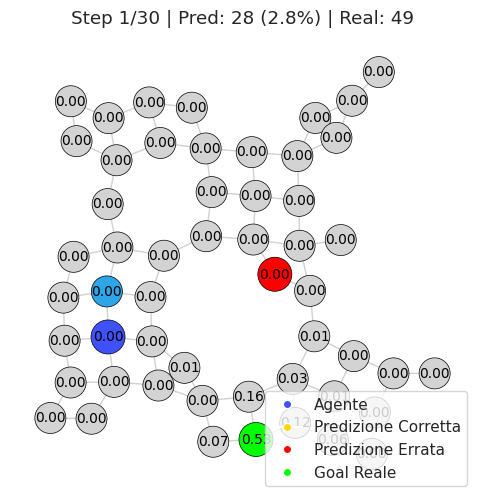

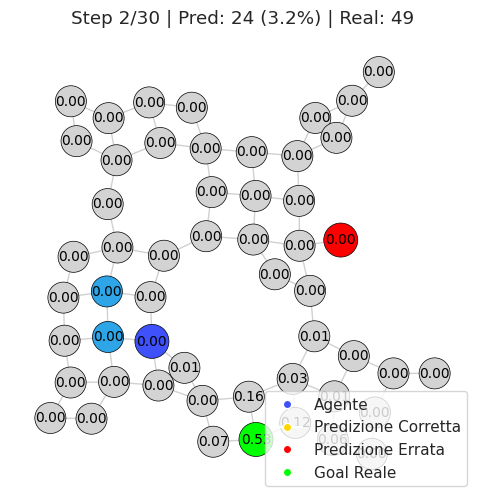

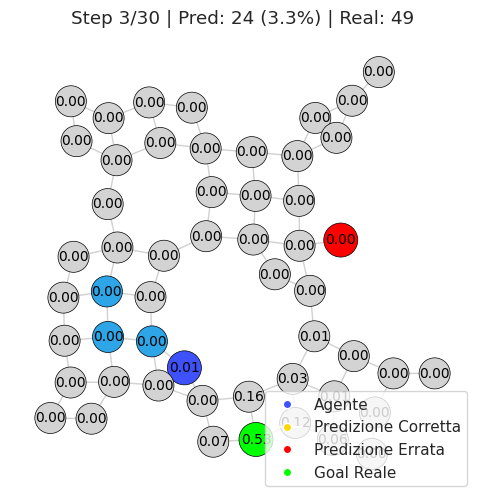

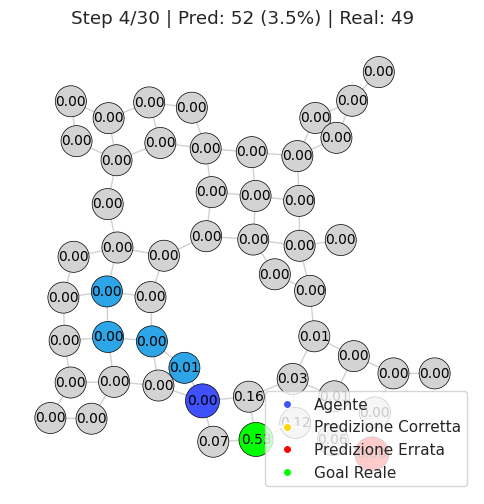

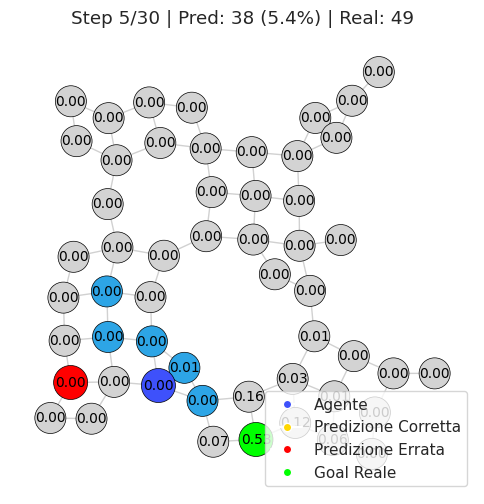

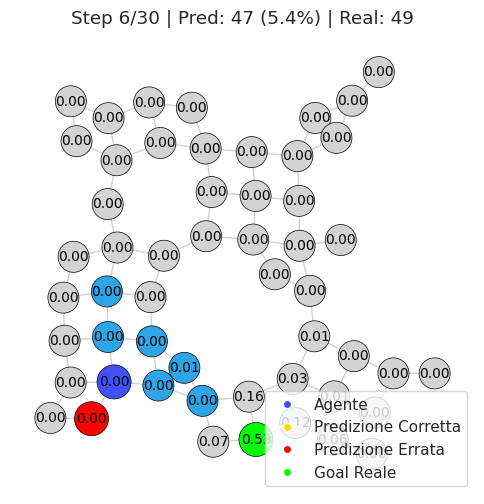

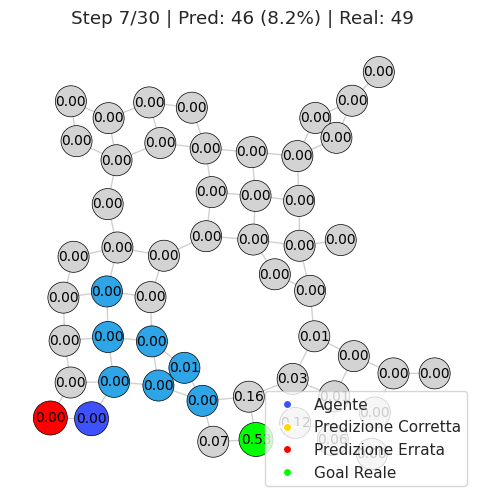

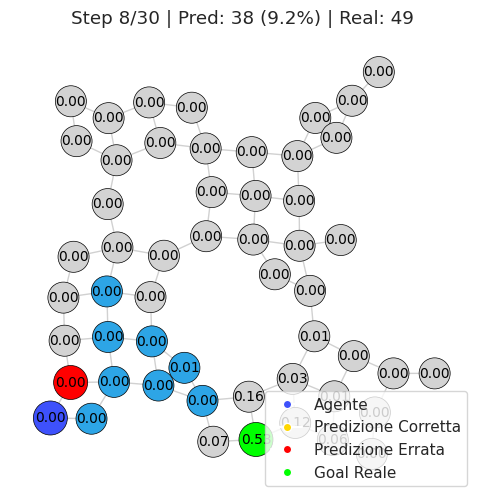

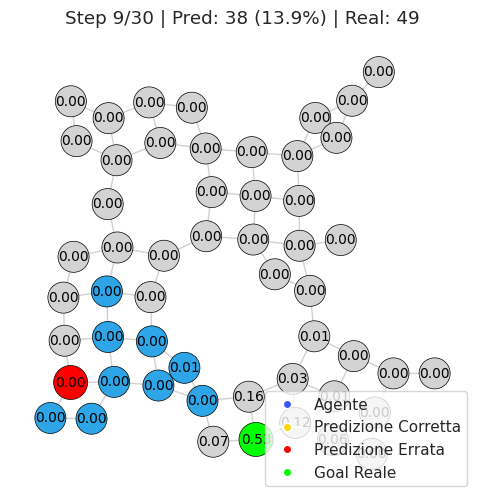

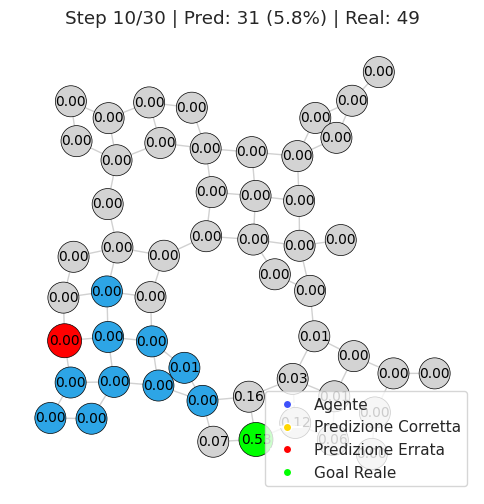

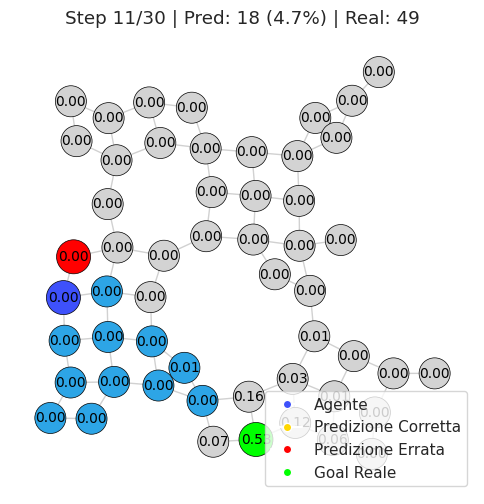

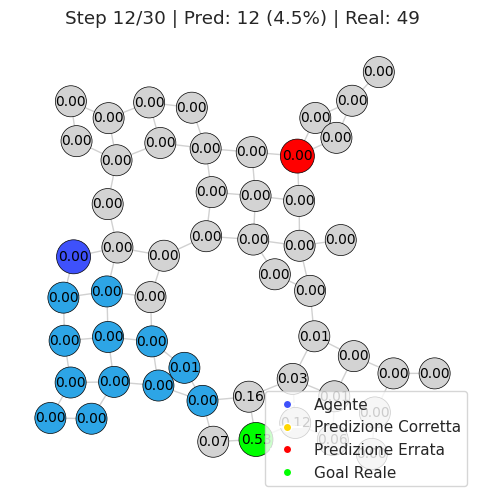

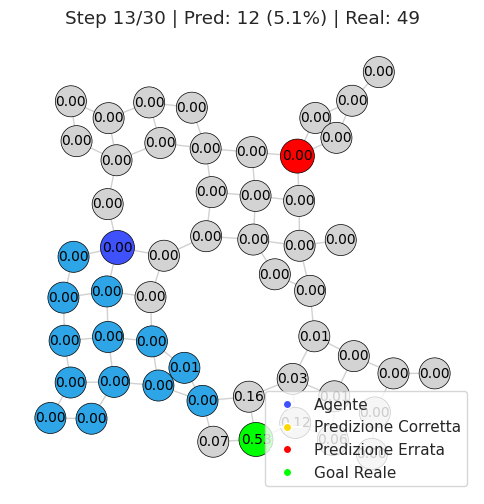

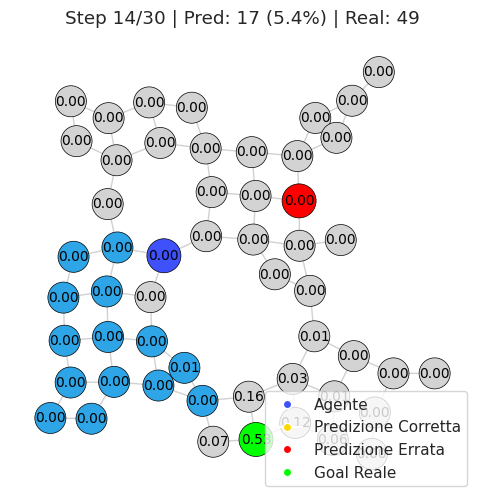

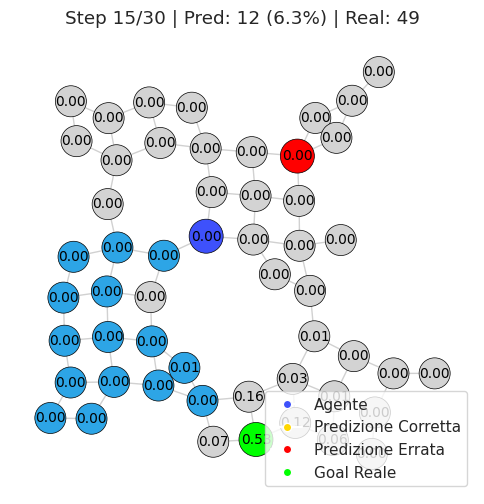

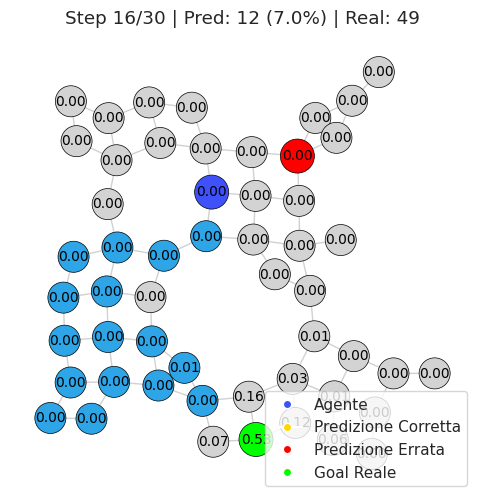

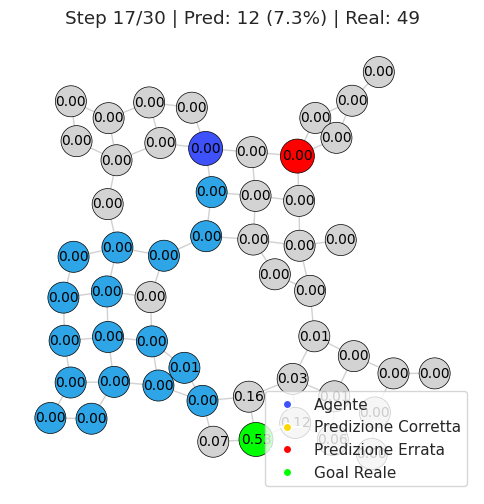

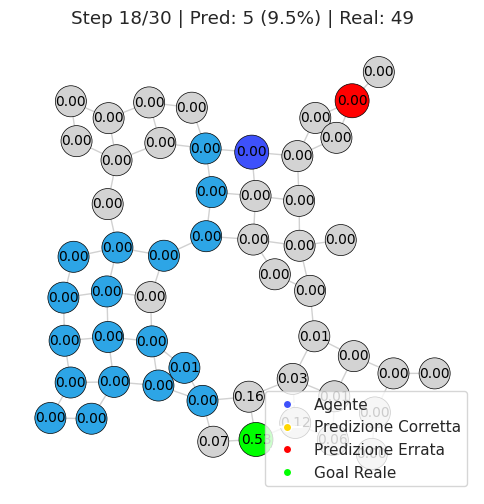

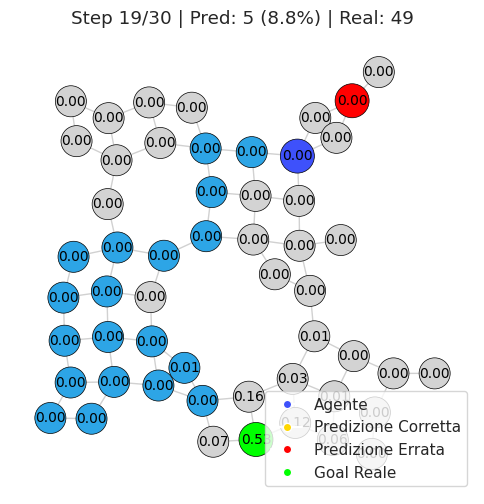

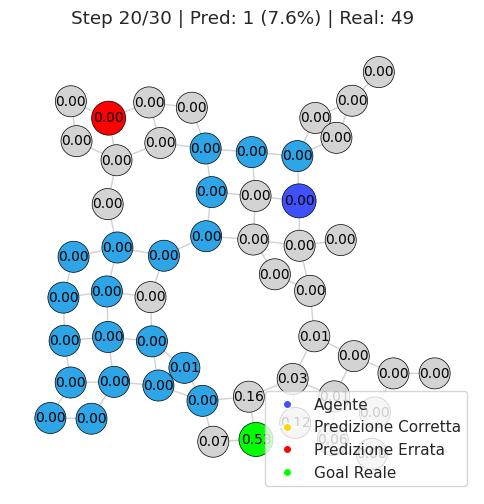

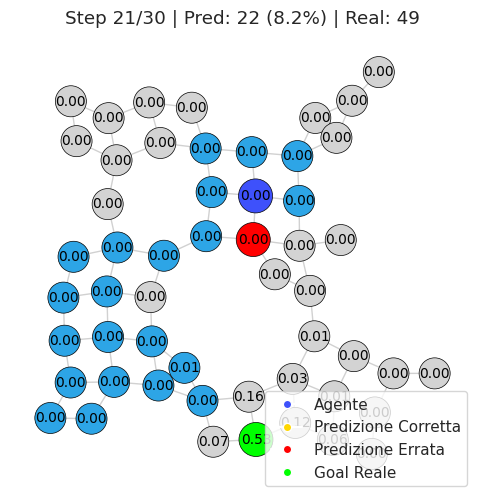

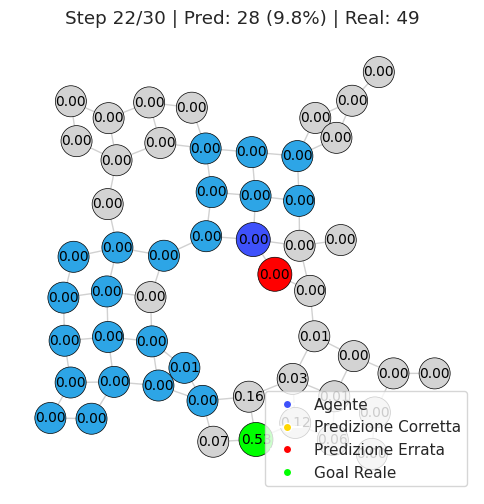

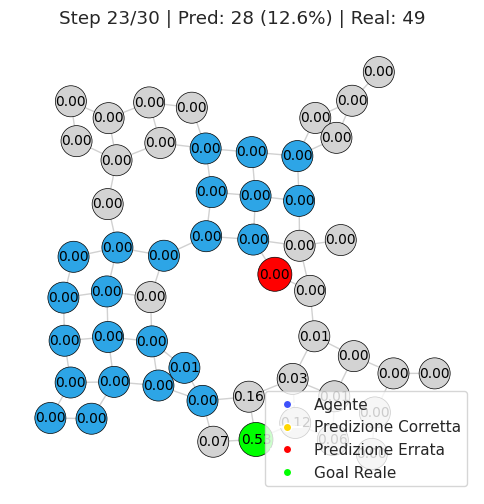

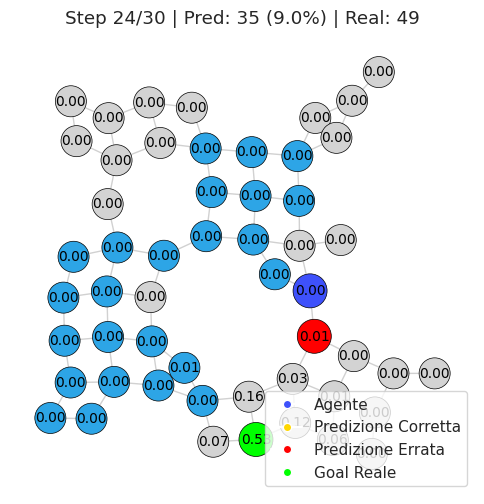

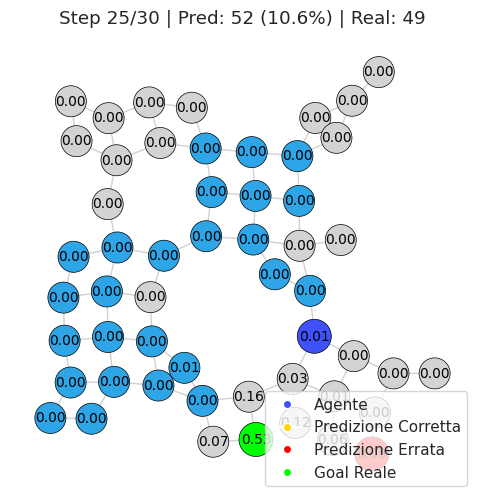

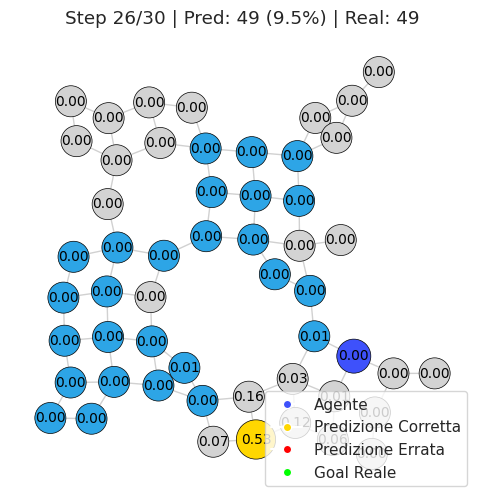

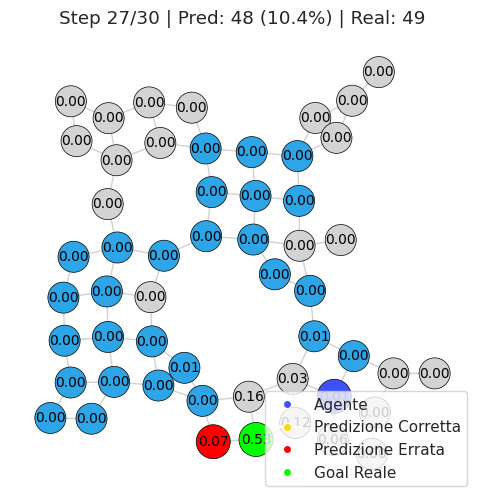

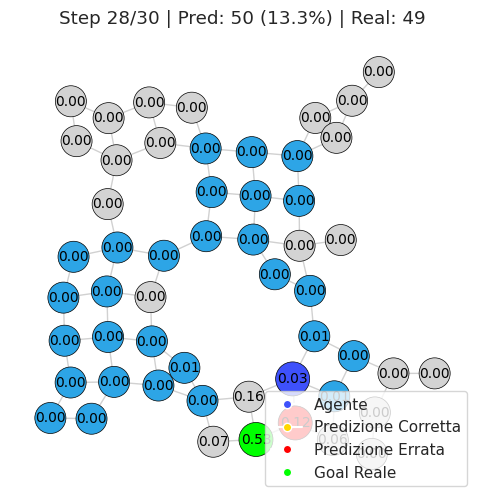

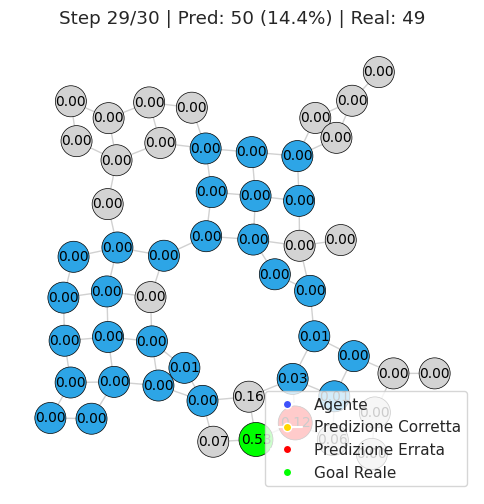

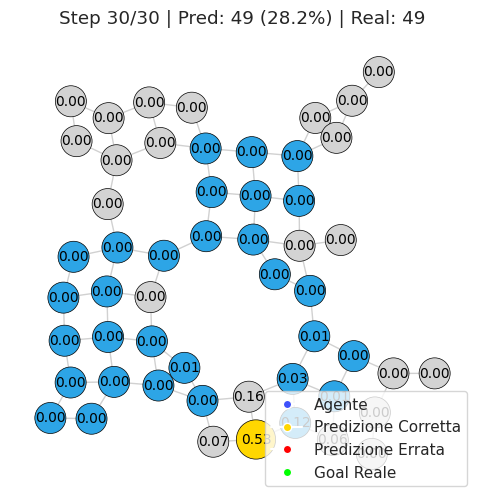

In [32]:
# --- Configurazione ---
mapIndex = 50
pathIndex = 6

# Setup Modello
model_test.eval()
device = next(model_test.parameters()).device 

print(f"\n--- Generazione Sequenza Completa: Mappa {mapIndex}, Percorso {pathIndex} ---")

# 1. Generazione Dati
try:
    # Forziamo percentage=100 per vedere tutto il percorso
    map_and_paths = goalRecognitionDataset.generate_entries(mapIndex, pathIndex, False, 100)
except TypeError:
    map_and_paths = goalRecognitionDataset.generate_entries(mapIndex, pathIndex, False)

print(f"Totale passi da visualizzare: {len(map_and_paths)}\n")

# 2. Setup Layout Fisso (per non far saltare i nodi durante l'animazione)
G_template = to_networkx(map_and_paths[0], to_undirected=True)
fixed_pos = nx.kamada_kawai_layout(G_template) 

# Labels statiche (valori target del dataset)
labels_dict = {i: f"{x:.2f}" for i, x in enumerate(map_and_paths[0].y.tolist())}

# --- Loop Principale ---
for i, data in enumerate(map_and_paths):
    data = data.to(device)
    
    # A. Inference
    with torch.no_grad():
        probs = get_prediction(model_test, data, device)

    # Dati predizione
    pred_idx = probs.argmax().item()
    pred_prob = probs[pred_idx].item()
    true_goal_idx = data.y.argmax().item()

    # B. Calcolo Aspetto Grafico
    colors, sizes = get_node_appearance(data, pred_idx, true_goal_idx)

    # C. Visualizzazione
    info_tuple = (pred_idx, pred_prob, true_goal_idx, i+1, len(map_and_paths))
    plot_simulation_step(data, fixed_pos, colors, sizes, labels_dict, info_tuple)

### Visualizzazione risultati della run migliore

In [27]:
"""
FASE DI RECUPERO E INIZIALIZZAZIONE DEL MODELLO OTTIMALE
Questo modulo interagisce con l'API di WandB per identificare, scaricare e 
caricare in memoria il modello che ha ottenuto le migliori performance 
durante le sessioni di training/sweep.
"""

# --- CONFIGURAZIONE PROGETTO ---
ENTITY = "m-lizza002-university-of-brescia"
PROJECT = "Node_Classificator"
METRIC_NAME = "val_topk"  # Metrica di riferimento per la selezione (Top-K Accuracy)
SAVE_DIR = "./gnn/" 

# --- 1. RICERCA AUTOMATICA NELL'INTERO PROGETTO ---
# Utilizzo delle API WandB per l'analisi dei metadati delle esecuzioni
print(f"[INFO] Inizio scansione del progetto {ENTITY}/{PROJECT}...")
api = wandb.Api()

# Recupero della lista di tutte le run associate al progetto
runs = api.runs(f"{ENTITY}/{PROJECT}")

if len(runs) == 0:
    raise ValueError(f"[ERRORE] Nessuna run trovata per il progetto {PROJECT}. Verificare ENTITY e PROJECT name.")

# Ordinamento delle run in base alla metrica specificata (METRIC_NAME)
# Viene selezionata la run con il valore massimo (reverse=True)
best_run = sorted(runs, key=lambda run: run.summary.get(METRIC_NAME, 0), reverse=True)[0]

best_run_id = best_run.id
best_config = best_run.config
best_metric_val = best_run.summary.get(METRIC_NAME)

print(f"--- MIGLIORE ESECUZIONE IDENTIFICATA ---")
print(f"ID Run: {best_run_id}")
print(f"Metrica target ({METRIC_NAME}): {best_metric_val:.4f}")
print(f"Origine: {best_run.sweep.id if best_run.sweep else 'Esecuzione manuale'}")
print(f"Configurazione ottimale: Hidden={best_config.get('hidden_channels')}, Layers={best_config.get('num_layers')}")

# --- 2. GESTIONE FILE E DOWNLOAD ARTIFACTS ---
# Definizione del path locale per i pesi del modello
MODEL_NAME = f"model_{best_run_id}.pth"
model_path = os.path.join(SAVE_DIR, MODEL_NAME)

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

if not os.path.exists(model_path):
    print(f"[WARNING] Pesi del modello non trovati localmente. Avvio download da WandB Cloud...")
    try:
        # Ricerca del file .pth tra i file caricati durante la run selezionata
        found = False
        for file in best_run.files():
            if file.name.endswith(".pth"):
                # Download del file nella directory di destinazione
                file.download(root=SAVE_DIR, replace=True)
                
                # Normalizzazione del nome del file per coerenza con il sistema locale
                if file.name != MODEL_NAME:
                    os.rename(os.path.join(SAVE_DIR, file.name), model_path)
                
                found = True
                print("[INFO] Download dei pesi completato con successo.")
                break
        
        if not found:
            print("[ERRORE] Nessun artifact con estensione .pth trovato nella run selezionata.")
    except Exception as e:
        print(f"[ERRORE] Fallimento durante il download: {e}")

# --- 3. ISTANZIAZIONE E CARICAMENTO DELLO STATO ---
# Selezione del device (CUDA/CPU) per l'inferenza
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ricostruzione dinamica dell'architettura basata sugli iperparametri della Best Run
model_test = NodeClassificator(
    in_channels=7, 
    hidden_channels=best_config.get('hidden_channels', 64),
    num_layers=best_config.get('num_layers', 3),
    dropout=0.0  # Il dropout viene azzerato in fase di test
).to(device)

# Caricamento dei pesi (state_dict) nel modello istanziato
if os.path.exists(model_path):
    print(f"[INFO] Caricamento pesi in corso da: {model_path}")
    state_dict = torch.load(model_path, map_location=device)
    model_test.load_state_dict(state_dict)
    
    # Impostazione del modello in modalità valutazione (disabilita Dropout e BatchNorm)
    model_test.eval()
    print("[SUCCESS] Modello configurato e pronto per la fase di test/analisi.")
else:
    print(f"[ERRORE CRITICO] Impossibile procedere: file dei pesi mancante per la run {best_run_id}.")

[INFO] Inizio scansione del progetto m-lizza002-university-of-brescia/Node_Classificator...
--- MIGLIORE ESECUZIONE IDENTIFICATA ---
ID Run: i6s65bid
Metrica target (val_topk): 0.5818
Origine: 8uzklkf6
Configurazione ottimale: Hidden=64, Layers=4
[INFO] Caricamento pesi in corso da: ./gnn/model_i6s65bid.pth
[SUCCESS] Modello configurato e pronto per la fase di test/analisi.


/tmp/ipykernel_1711729/3184602291.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


In [ ]:
def collect_test_results(model: nn.Module, loader: DataLoader, device: torch.device, k: int = 10) -> pd.DataFrame:
    """
    Esegue l'inferenza sul set di test e raccoglie risultati dettagliati per l'analisi statistica.

    La funzione gestisce la natura "batchata" dei dati di PyTorch Geometric, separando i 
    singoli grafi all'interno di un batch per calcolare correttamente le probabilità 
    (Softmax locale) e le metriche di accuratezza (Top-1 e Top-K).
    """
    model.eval()
    results = []
    
    print(f"[INFO] Avvio raccolta dati (Batch-Corrected) - Top-1 e Top-{k}...")
    
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
            data = data.to(device)
            
            # Recupero del vettore batch: associa ogni nodo al rispettivo grafo nel batch.
            # Fondamentale per separare le predizioni in un ambiente multi-grafo.
            batch_vec = data.batch if hasattr(data, 'batch') else torch.zeros(data.num_nodes, dtype=torch.long, device=device)
            
            # Passaggio in avanti: ottiene i logit per tutti i nodi presenti nel batch
            logits = model(data.x, data.edge_index, batch_vec)
            logits = logits.squeeze() 
            
            # --- SEPARAZIONE DEI GRAFI NEL BATCH ---
            num_graphs = data.num_graphs
            
            for g_idx in range(num_graphs):
                # 1. Creazione maschera booleana per isolare i nodi appartenenti al grafo i-esimo
                mask = (batch_vec == g_idx)
                
                # 2. Estrazione dei logit e dei target (Y) relativi solo al grafo corrente
                g_logits = logits[mask]
                g_y = data.y[mask]
                
                # 3. Calcolo Softmax: deve essere eseguito sulla dimensione del singolo grafo
                # affinché la somma delle probabilità dei nodi del grafo sia pari a 1.
                probs = torch.nn.functional.softmax(g_logits, dim=0)
                
                # 4. Identificazione del Goal Reale e della Predizione Top-1
                # true_goal è l'indice del nodo con il valore massimo nel target (ground truth)
                pred_top1 = probs.argmax().item()
                true_goal = g_y.argmax().item()
                
                # 5. Calcolo Top-K Accuracy
                # Si gestisce il caso limite in cui il grafo ha meno di K nodi totali
                curr_k = min(k, len(probs))
                _, top_k_indices = torch.topk(probs, curr_k, dim=0)
                
                # 6. Verifica correttezza
                is_correct_top1 = (pred_top1 == true_goal)
                is_correct_topk = (top_k_indices == true_goal).any().item()
                
                # Confidenza: la probabilità assegnata dal modello alla sua scelta migliore
                confidence = probs[pred_top1].item()
                
                # 7. Archiviazione dei risultati e dei metadati per l'analisi post-hoc
                entry = {
                    'is_correct': is_correct_top1,      
                    f'is_top{k}': is_correct_topk,      
                    'confidence': confidence,
                    'true_goal': true_goal,
                    
                    # I metadati sono scalari salvati per ogni grafo all'interno del batch
                    'optimality': data.optimality[g_idx].item(),
                    'obstacle_perc': data.obstacle_perc[g_idx].item(),
                    'path_completion': data.path_completion[g_idx].item(),
                    'avg_len': data.avg_len[g_idx].item()
                }
                results.append(entry)
                
    print(f"[SUCCESS] Elaborazione completata: {len(results)} campioni raccolti.")
    return pd.DataFrame(results)

[INFO] Generazione database risultati in corso...
[INFO] Avvio raccolta dati (Batch-Corrected) - Top-1 e Top-10...
[SUCCESS] Elaborazione completata: 16733 campioni raccolti.
[INFO] Elaborazione grafici analitici...


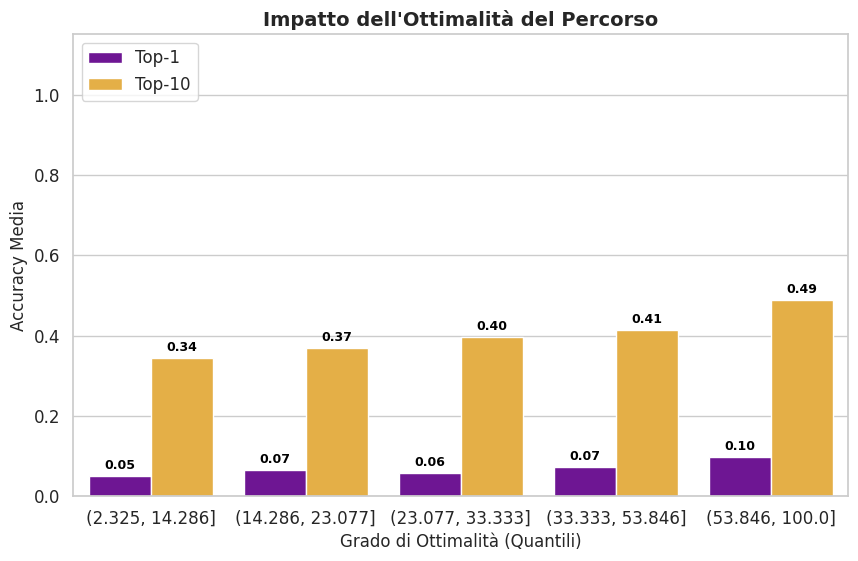

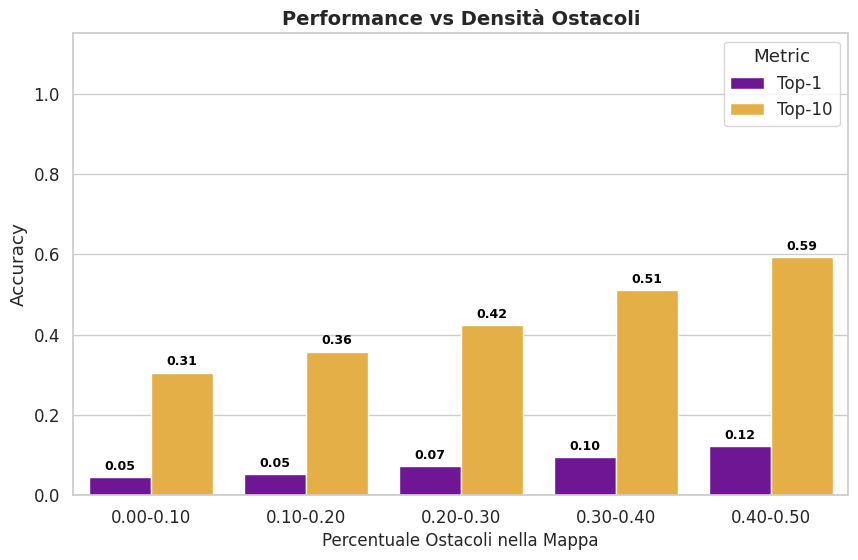

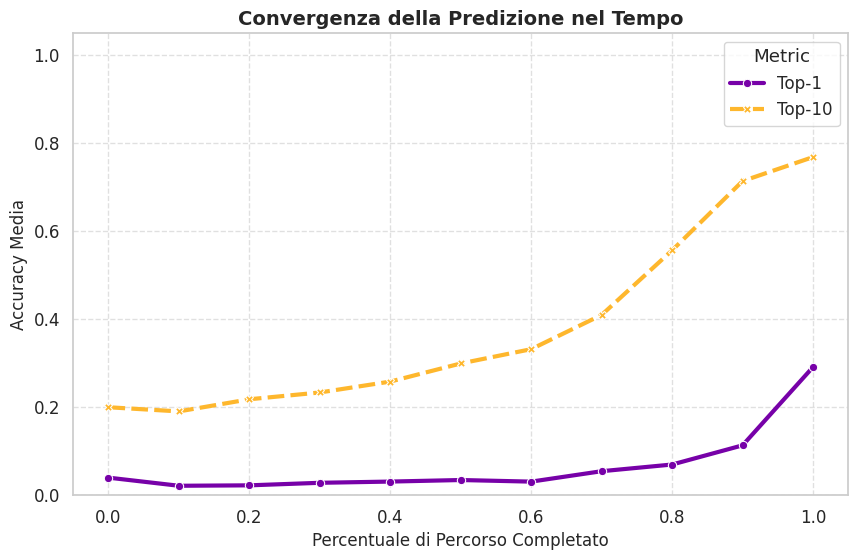


       RISULTATI FINALI       
Top-1 Accuracy:  6.81%
Top-10 Accuracy: 40.14%


In [ ]:
# --- CONFIGURAZIONE GLOBALE VISUALIZZAZIONE ---
# Impostazione del tema estetico e della palette colori per la coerenza del report
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
COMPARE_PALETTE = {"Top-1": "#7701A8", "Top-10": "#FEB72D"} 

# --- 1. FUNZIONI HELPER PER IL PROCESSING DATI ---

def _prepare_comparison_data(df: pd.DataFrame, bin_col: str, k_label: str = "Top-10") -> pd.DataFrame:
    """
    Trasforma il DataFrame in formato 'Tidy' (long-form) per facilitare il plotting con Seaborn.
    
    Esegue il raggruppamento per bin e calcola la media delle accuratezze, poi effettua 
    un'operazione di melting per separare le metriche Top-1 e Top-K in righe distinte.
    """
    top_k_col = [c for c in df.columns if 'is_top' in c]
    if not top_k_col:
        raise ValueError("[ERRORE] Colonna 'is_topX' non trovata nel DataFrame.")
    top_k_col = top_k_col[0] 
    
    # Raggruppamento e calcolo medie per bin
    grouped = df.groupby(bin_col, observed=False)[['is_correct', top_k_col]].mean().reset_index()
    
    # Trasformazione da formato wide a long
    melted = grouped.melt(id_vars=bin_col, 
                          value_vars=['is_correct', top_k_col],
                          var_name='Metric', value_name='Accuracy')
    
    melted['Metric'] = melted['Metric'].replace({'is_correct': 'Top-1', top_k_col: k_label})
    return melted

def add_bar_labels(ax: plt.Axes):
    """
    Utility per aggiungere etichette numeriche sopra le barre di un grafico.
    """
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.2f}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', 
                        fontsize=9, fontweight='bold', color='black',
                        xytext=(0, 3), textcoords='offset points')

# --- 2. FUNZIONI DI PLOTTING ---

def plot_optimality_comparison(df: pd.DataFrame):
    """Analizza come l'accuratezza cambia in base a quanto l'agente è stato efficiente."""
    plt.figure(figsize=(10, 6))
    df_temp = df.copy().dropna(subset=['optimality'])
    
    # Divisione in 5 quantili per garantire una distribuzione uniforme dei campioni
    try:
        df_temp['opt_bin'] = pd.qcut(df_temp['optimality'], q=5, duplicates='drop')
    except ValueError:
        df_temp['opt_bin'] = df_temp['optimality'].round(2)
        
    plot_data = _prepare_comparison_data(df_temp, 'opt_bin')
    ax = sns.barplot(data=plot_data, x='opt_bin', y='Accuracy', hue='Metric', palette=COMPARE_PALETTE)
    add_bar_labels(ax)
    
    plt.title("Impatto dell'Ottimalità del Percorso", fontsize=14, fontweight='bold')
    plt.xlabel("Grado di Ottimalità (Quantili)", fontsize=12)
    plt.ylabel("Accuracy Media", fontsize=12)
    plt.ylim(0, 1.15)
    plt.legend(loc='upper left')
    plt.show()

def plot_obstacles_comparison(df: pd.DataFrame):
    """Analizza l'effetto della densità degli ostacoli sulla capacità predittiva."""
    plt.figure(figsize=(10, 6))
    df_temp = df.copy()
    
    # Creazione di bin equispaziati per la densità degli ostacoli
    max_obs = df_temp['obstacle_perc'].max()
    bins = np.linspace(0, max_obs, 6)
    df_temp['temp_bin'] = pd.cut(df_temp['obstacle_perc'], bins=bins, include_lowest=True)
    
    df_temp['obs_bin'] = df_temp['temp_bin'].apply(lambda i: f"{max(0, i.left):.2f}-{i.right:.2f}")
    df_temp = df_temp.sort_values('temp_bin')
    
    plot_data = _prepare_comparison_data(df_temp, 'obs_bin')
    ax = sns.barplot(data=plot_data, x='obs_bin', y='Accuracy', hue='Metric', palette=COMPARE_PALETTE)
    add_bar_labels(ax)
    
    plt.title("Performance vs Densità Ostacoli", fontsize=14, fontweight='bold')
    plt.xlabel("Percentuale Ostacoli nella Mappa", fontsize=12)
    plt.ylim(0, 1.15)
    plt.show()

def plot_early_prediction_comparison(df: pd.DataFrame):
    """
    Visualizza la convergenza della predizione.
    Mostra come l'accuratezza cresce man mano che l'agente percorre la mappa.
    """
    plt.figure(figsize=(10, 6))
    df_temp = df.copy()
    df_temp['completion_bin'] = df_temp['path_completion'].round(1)
    plot_data = _prepare_comparison_data(df_temp, 'completion_bin')
    
    sns.lineplot(data=plot_data, x='completion_bin', y='Accuracy', hue='Metric',
                 palette=COMPARE_PALETTE, style='Metric', markers=True, linewidth=3)
    
    plt.title("Convergenza della Predizione nel Tempo", fontsize=14, fontweight='bold')
    plt.xlabel("Percentuale di Percorso Completato", fontsize=12)
    plt.ylabel("Accuracy Media", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(0, 1.05)
    plt.show()

# --- 3. ESECUZIONE ANALISI ---

if 'model_test' in globals():
    print("[INFO] Generazione database risultati in corso...")
    df_results = collect_test_results(model_test, test_loader, device, k=10)
    
    print("[INFO] Elaborazione grafici analitici...")
    plot_optimality_comparison(df_results)
    plot_obstacles_comparison(df_results)
    plot_early_prediction_comparison(df_results)
    
    # Calcolo metriche finali aggregate
    acc_top1 = df_results['is_correct'].mean() * 100
    acc_top10 = df_results['is_top10'].mean() * 100
    
    print("\n" + "="*30)
    print("       RISULTATI FINALI       ")
    print("="*30)
    print(f"Top-1 Accuracy:  {acc_top1:.2f}%")
    print(f"Top-10 Accuracy: {acc_top10:.2f}%")
    print("="*30)
else:
    print("[ERROR] 'model_test' non trovato. Caricare il modello prima di eseguire l'analisi.")